<a href="https://colab.research.google.com/github/LeaYeh/mini-transformer/blob/main/hw1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TODO**

## **Simple Baseline**

* [x] Run sample code

## **Medium Baseline**
* [ ] Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* [ ] Feature selection (what other features are useful?)
    * Expirement and note different method
    * A/B testing model performance
* [ ] DNN architecture (layers? dimension? activation function?)
* [ ] Training (mini-batch? optimizer? learning rate?)
* [ ] L2 regularization
* [ ] There are some mistakes in the sample code, can you find them?

In [1]:
import os

In [2]:
data_folder = './work/related_therory/NTU_ML_20201/data/ml2021spring-hw1'  # folder to save data

train_path = os.path.join(data_folder, 'covid.train.csv')
test_path = os.path.join(data_folder, 'covid.test.csv')

output_folder = './work/related_therory/NTU_ML_20201/output'  # folder to save output

In [3]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
myseed = 42

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [5]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [6]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [7]:
train_dataset = COVID19Dataset(train_path)
test_dataset = COVID19Dataset(test_path, mode='test')

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [8]:
len(train_dataset)

2430

In [9]:
pd.DataFrame(train_dataset.data.numpy()).describe()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
count,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,...,2.430000e+03,2.430000e+03,2.430000e+03,2430.000000,2.430000e+03,2.430000e+03,2.430000e+03,2.430000e+03,2.430000e+03,2.430000e+03
mean,0.024691,0.024691,0.024691,0.025103,0.024691,0.024691,0.025103,0.024691,0.024691,0.025103,...,8.791072e-07,-2.260561e-07,-7.535205e-07,0.000000,-3.767602e-08,4.521123e-07,-2.825702e-08,-5.525816e-07,-3.516429e-07,3.767602e-07
std,0.155217,0.155217,0.155217,0.156468,0.155217,0.155217,0.156468,0.155216,0.155216,0.156468,...,1.000000e+00,1.000000e+00,9.999998e-01,1.000000,1.000000e+00,9.999994e-01,1.000001e+00,9.999999e-01,9.999996e-01,1.000000e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.626976e+00,-2.289557e+00,-2.192807e+00,-1.738353,-1.575330e+00,-2.258796e+00,-2.869911e+00,-2.129226e+00,-2.667851e+00,-2.189435e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-8.507931e-01,-6.006017e-01,-8.222126e-01,-0.801224,-6.379388e-01,-7.308154e-01,-7.071488e-01,-7.040991e-01,-8.155820e-01,-7.681473e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.548349e-02,-6.121446e-02,-7.273870e-03,-0.115566,-1.770150e-01,-1.704070e-01,-6.352893e-02,-1.781109e-01,1.763778e-01,-1.087954e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.053433e-01,8.197246e-01,8.161061e-01,0.716363,3.273488e-01,6.389135e-01,7.084531e-01,5.435468e-01,7.858468e-01,6.776648e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.330748e+00,2.077374e+00,2.181660e+00,3.037862,5.492065e+00,4.669538e+00,3.460657e+00,3.376009e+00,2.066225e+00,2.650917e+00


In [10]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [11]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

In [12]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [13]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [14]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [15]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs(os.path.join(output_folder, 'models'), exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

save_path = os.path.join(output_folder, 'models', 'model.pth')

In [16]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs(os.path.join(output_folder, 'models'), exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

save_path = os.path.join(output_folder, 'models', 'model.pth')

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': save_path  # your model will be saved here
}

In [17]:
tr_set = prep_dataloader(train_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(train_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(test_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [18]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [19]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 89.6754)
Saving model (epoch =    2, loss = 43.5981)
Saving model (epoch =    3, loss = 25.5309)
Saving model (epoch =    4, loss = 14.6982)
Saving model (epoch =    5, loss = 10.1349)
Saving model (epoch =    6, loss = 6.9069)
Saving model (epoch =    7, loss = 5.6462)
Saving model (epoch =    8, loss = 4.8304)
Saving model (epoch =    9, loss = 4.1952)
Saving model (epoch =   10, loss = 3.7638)
Saving model (epoch =   11, loss = 3.4444)
Saving model (epoch =   12, loss = 3.1495)
Saving model (epoch =   13, loss = 2.9241)
Saving model (epoch =   14, loss = 2.6741)
Saving model (epoch =   15, loss = 2.5388)
Saving model (epoch =   16, loss = 2.3636)
Saving model (epoch =   17, loss = 2.2078)
Saving model (epoch =   18, loss = 2.1226)
Saving model (epoch =   19, loss = 1.9751)
Saving model (epoch =   20, loss = 1.8684)
Saving model (epoch =   21, loss = 1.7887)
Saving model (epoch =   22, loss = 1.7133)
Saving model (epoch =   23, loss = 1.6718)
Saving

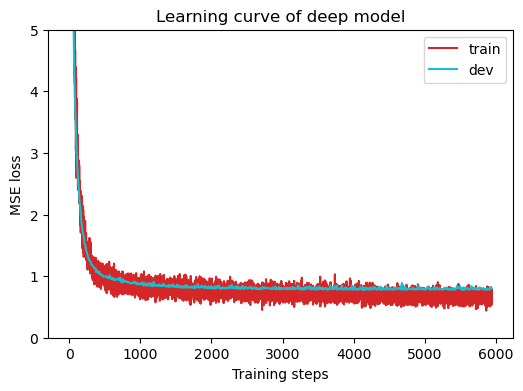

In [20]:
plot_learning_curve(model_loss_record, title='deep model')

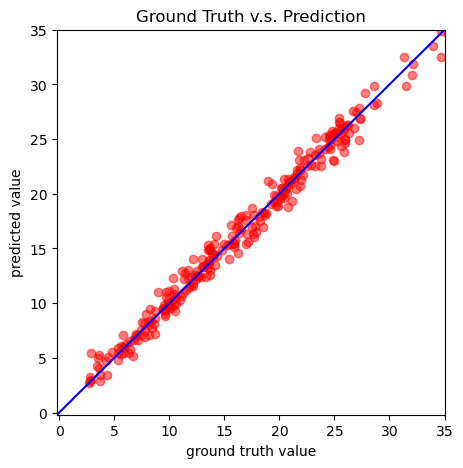

In [21]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [22]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model

save_pred(preds, os.path.join(output_folder, 'pred_baseline.csv'))         # save prediction file to pred.csv

Saving results to ./work/related_therory/NTU_ML_20201/output/pred_baseline.csv


--------

# Feature Selection

In [34]:
train_df = pd.read_csv(train_path)

In [38]:
train_df[['tested_positive', 'tested_positive.1', 'tested_positive.2']]

,tested_positive,tested_positive.1,tested_positive.2
0,19.586492,20.151838,20.704935
1,20.151838,20.704935,21.292911
2,20.704935,21.292911,21.166656
3,21.292911,21.166656,19.896607
4,21.166656,19.896607,20.178428
...,...,...,...
2695,13.869286,13.434180,13.008853
2696,13.434180,13.008853,12.725638
2697,13.008853,12.725638,12.613441
2698,12.725638,12.613441,12.477227


In [36]:
train_df.columns

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea